In [28]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from functools import wraps
import time
import os
import pandas as pd
import seaborn as sns

In [2]:
df = pd.DataFrame(columns=["time", "nodes", "edges", "best_w",  "iterations", "k"])

In [3]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result1, result2 = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start
        print(f"{func.__name__} took {elapsed:.6f} seconds")
        return (result1, result2, elapsed)
    return wrapper

In [4]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight = "weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight = "weight")
    best_w = best_tree.size(weight = "weight")
    best_nodes = set(best_tree.nodes())

    return best_tree, best_w, best_nodes

In [5]:
def evaluate(G, nodes):
    subgraph = G.subgraph(nodes)
    if not nx.is_connected(subgraph):
        return None, float("inf")
    T = nx.minimum_spanning_tree(subgraph, weight = "weight")
    return T, T.size(weight = "weight")

In [6]:
def shake(G, current_nodes, k, terminals):
    nodes = list(set(G.nodes()) - set(terminals))
    new_nodes = set(current_nodes)
    
    for _ in range(k):
        if random.random() < 0.5 and len(new_nodes - set(terminals)) > 0:
            v = random.choice(list(new_nodes - set(terminals)))
            new_nodes.remove(v)
        else:
            v = random.choice(nodes)
            new_nodes.add(v)
    return new_nodes

In [7]:
def local_search(G, nodes, terminals):
    improved = True
    best_nodes = set(nodes)
    best_tree, best_w = evaluate(G, best_nodes)
    
    while improved:
        improved = False
        for v in list(best_nodes - set(terminals)):
            candidate = best_nodes - {v}
            T, w = evaluate(G, candidate)
            if w < best_w:
                best_nodes, best_tree, best_w = candidate, T, w
                improved = True
                break
    return best_tree, best_w, best_nodes

In [8]:
@timeit
def vns(G, terminals, iterations, max_k):
    best_tree, best_w, best_nodes = initialize(G, terminals)

    for _ in range(iterations):
        k = 1
        while k <= max_k:
            shaken_nodes = shake(G, best_nodes, k, terminals)
            T, w = evaluate(G, shaken_nodes)
            
            if w == float("inf"):
                k += 1
                continue

            T_ls, w_ls, nodes_ls = local_search(G, shaken_nodes, terminals)
            
            if w_ls < best_w:
                best_tree, best_w, best_nodes = T_ls, w_ls, nodes_ls
                k = 1
            else:
                k += 1
     
    return best_tree, best_w

In [83]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [84]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [85]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

vns took 0.193518 seconds


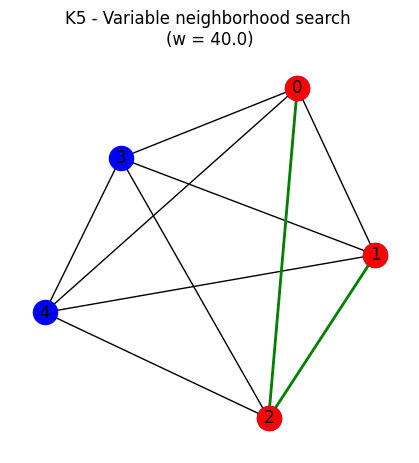

vns took 0.189164 seconds


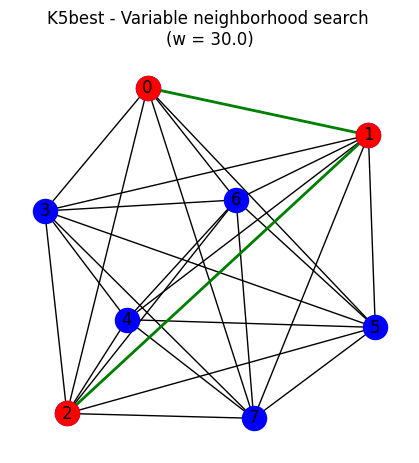

vns took 0.294373 seconds


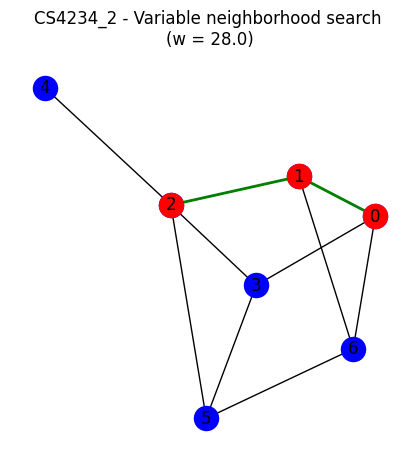

In [112]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = vns(G, terminals, 100, 5)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
    plt.show()

In [9]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [113]:
G, terminals = read_stp('hc6u.stp')

vns took 0.680588 seconds


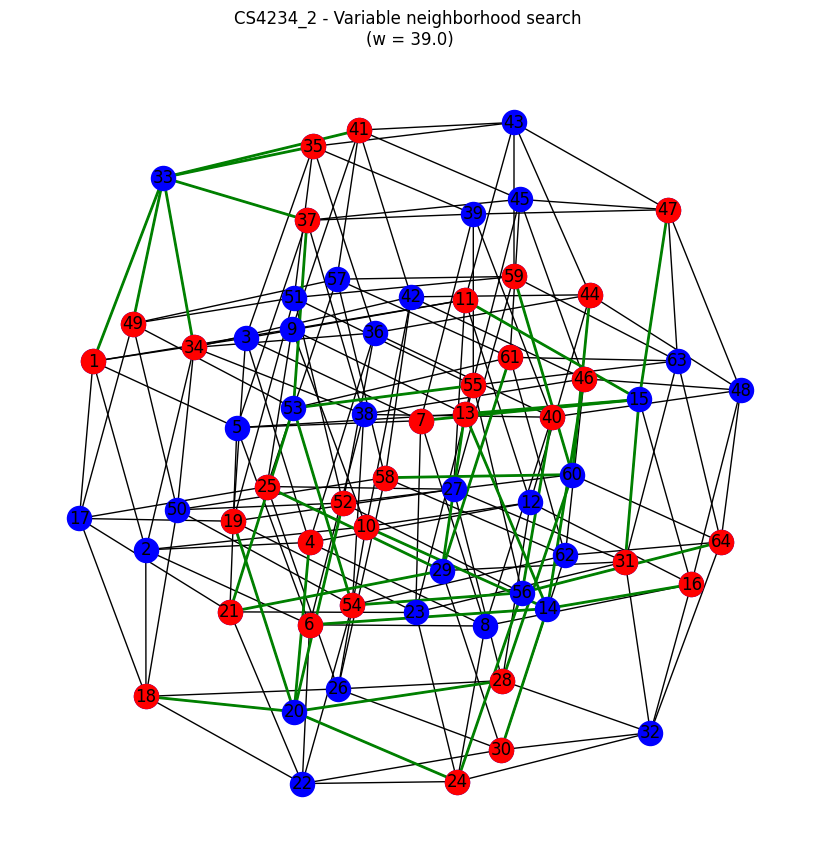

In [114]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
plt.show()

In [115]:
G, terminals = read_stp('hc12u.stp')

vns took 21917.324850 seconds


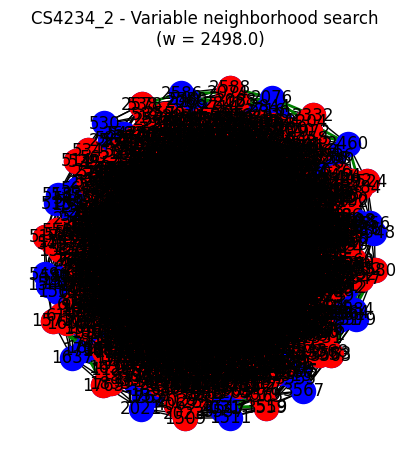

In [116]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (4,4))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search  \n(w = {w})")
plt.show()

In [10]:
def tests(directory):
    global df
    df = df[0:0]
    results = {}
    
    for fname in os.listdir(directory):
        if fname.endswith(".stp"):
            path = os.path.join(directory, fname)
            try:
                G, terminals = read_stp(path) 
                results[fname] = (G, terminals)
                print(f"{fname} : (Number of nodes = {G.number_of_nodes()}, number of edges = {G.number_of_edges()}, number of terminals = {len(terminals)})")
                test_big(G, terminals)
            except Exception as e:
                print(f"File error {fname}: {e}")
        print("\n")
    return 

In [11]:
def test_big(G, terminals):
    global df
    num_iterations = [10,100,1000]
    ks = [2,3,5,7]
    
    for iterations in num_iterations:
        for k in ks:
            best_tree, best_w, elapsed = vns(G, terminals, iterations, k)
            new_row = {
                "time": round(elapsed, 6),
                "nodes" : G.number_of_nodes(),
                "edges" : G.number_of_edges(),
                "best_w": best_w,
                "iterations": iterations,
                "k" : k
            }
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [19]:
tests('../Big graphs')
df.to_csv('results_vns.csv')
df

cc9-2u.stp : (Number of nodes = 512, number of edges = 2304, number of terminals = 64)
vns took 11.744486 seconds
vns took 10.691822 seconds
vns took 11.796214 seconds
vns took 12.449404 seconds
vns took 20.681632 seconds
vns took 20.921901 seconds
vns took 27.451377 seconds
vns took 22.645178 seconds
vns took 77.835187 seconds
vns took 95.238393 seconds
vns took 149.009576 seconds
vns took 164.810462 seconds


hc6u.stp : (Number of nodes = 64, number of edges = 192, number of terminals = 32)
vns took 0.192606 seconds
vns took 0.200391 seconds
vns took 0.220835 seconds
vns took 0.184722 seconds
vns took 0.497195 seconds
vns took 0.507760 seconds
vns took 0.766242 seconds
vns took 0.841332 seconds
vns took 3.169265 seconds
vns took 4.655147 seconds
vns took 6.191856 seconds
vns took 6.887611 seconds


hc7u.stp : (Number of nodes = 128, number of edges = 448, number of terminals = 64)
vns took 0.933796 seconds
vns took 0.912577 seconds
vns took 1.005965 seconds
vns took 1.215488 seconds


,time,nodes,edges,best_w,iterations,k
0,11.744486,512,2304,193.0,10,2
1,10.691822,512,2304,193.0,10,3
2,11.796214,512,2304,192.0,10,5
3,12.449404,512,2304,192.0,10,7
4,20.681632,512,2304,188.0,100,2
...,...,...,...,...,...,...
115,0.424569,64,192,32.0,100,7
116,1.673403,64,192,32.0,1000,2
117,3.775858,64,192,32.0,1000,3
118,2.810591,64,192,32.0,1000,5


In [15]:
df.to_csv('results_vns.csv')

In [20]:
sum(df["time"])

11009.287508000003

In [17]:
max(df["time"])

1045.127333

In [21]:
rows_per_graph = 12
df["graph_id"] = df.index // rows_per_graph + 1

In [22]:
graph_names = [ "cc9-2u", "hc6u", "hc7u", "hc9u", "cc3-5u", "hc8u", "cc5-3u", "cc6-3u", "hc10u", "cc6-2u"]
df["graph_name"] = df["graph_id"].map(lambda i: graph_names[i-1])

In [23]:
df

,time,nodes,edges,best_w,iterations,k,graph_id,graph_name
0,11.744486,512,2304,193.0,10,2,1,cc9-2u
1,10.691822,512,2304,193.0,10,3,1,cc9-2u
2,11.796214,512,2304,192.0,10,5,1,cc9-2u
3,12.449404,512,2304,192.0,10,7,1,cc9-2u
4,20.681632,512,2304,188.0,100,2,1,cc9-2u
...,...,...,...,...,...,...,...,...
115,0.424569,64,192,32.0,100,7,10,cc6-2u
116,1.673403,64,192,32.0,1000,2,10,cc6-2u
117,3.775858,64,192,32.0,1000,3,10,cc6-2u
118,2.810591,64,192,32.0,1000,5,10,cc6-2u


In [24]:
grouped = df.groupby("graph_name").agg({
    "best_w": ["min", "max", "mean"],
    "time": ["mean", "max"]
})
print(grouped)

           best_w                           time            
              min    max        mean        mean         max
graph_name                                                  
cc3-5u       36.0   36.0   36.000000    3.437525   12.810394
cc5-3u       74.0   82.0   78.083333    8.538903   31.223608
cc6-2u       32.0   33.0   32.083333    1.202460    4.433943
cc6-3u      208.0  218.0  212.666667  166.006979  498.163603
cc9-2u      180.0  193.0  186.583333   52.106303  164.810462
hc10u       593.0  654.0  622.333333  556.248997  933.986101
hc6u         39.0   40.0   39.083333    2.026247    6.887611
hc7u         77.0   91.0   80.750000    5.467734   16.659827
hc8u        150.0  158.0  153.666667   21.228910   54.728195
hc9u        296.0  377.0  336.333333  101.176568  216.080397


In [26]:
os.makedirs("plots_vns", exist_ok = True)

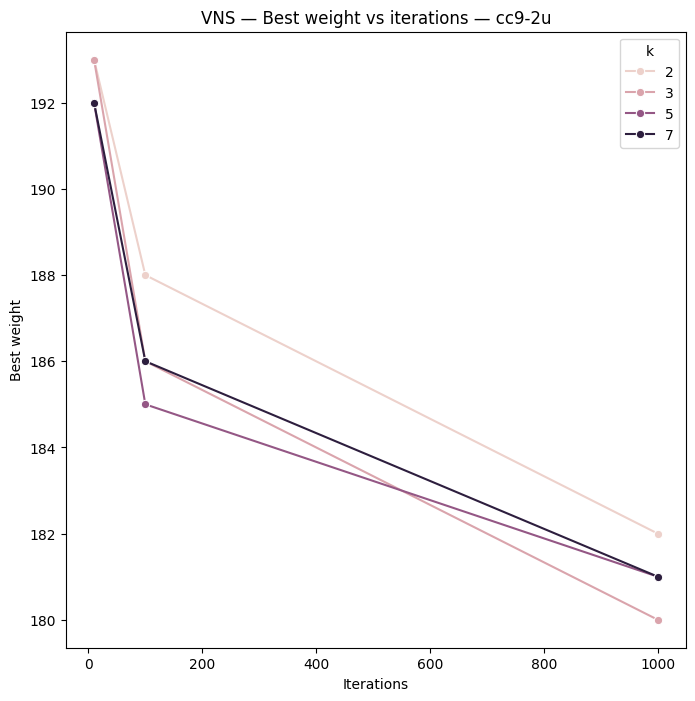

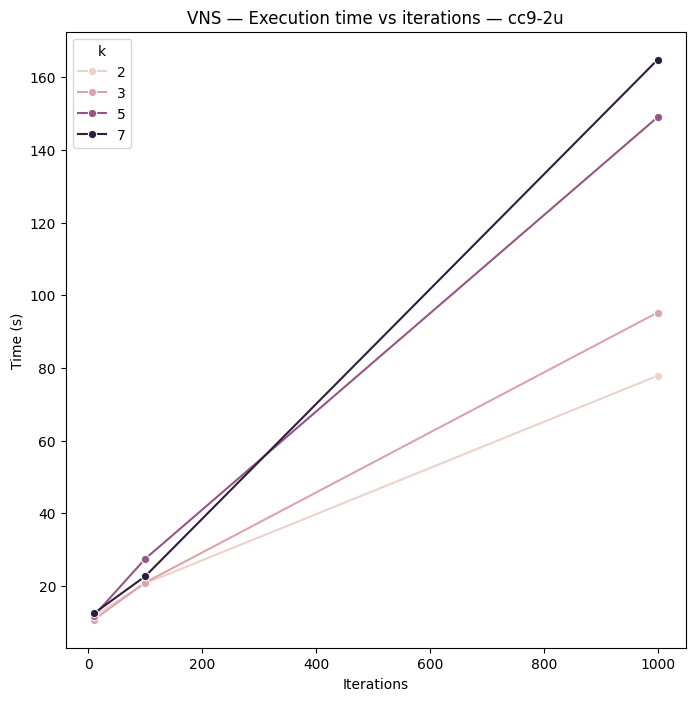

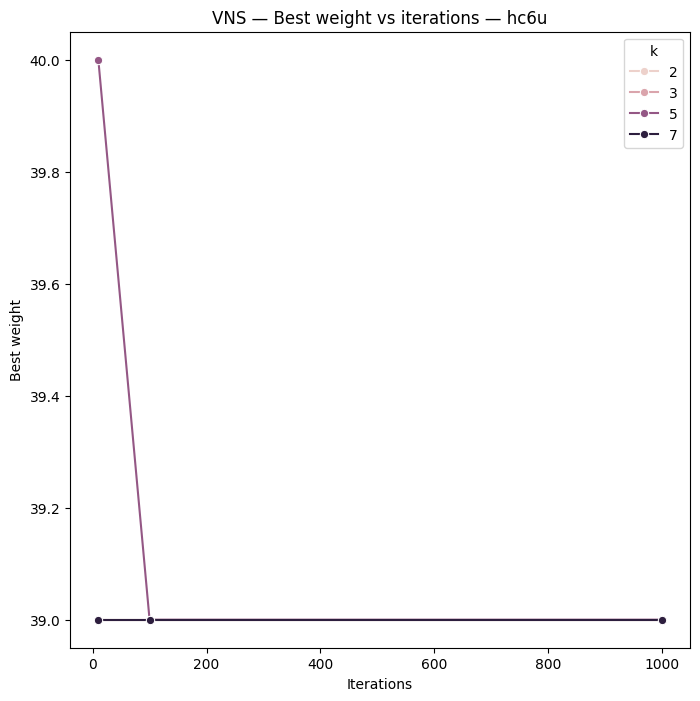

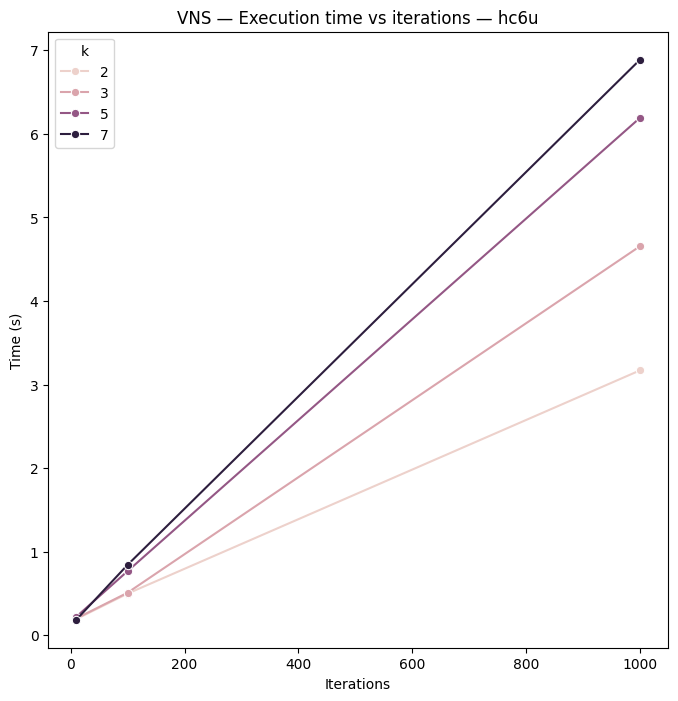

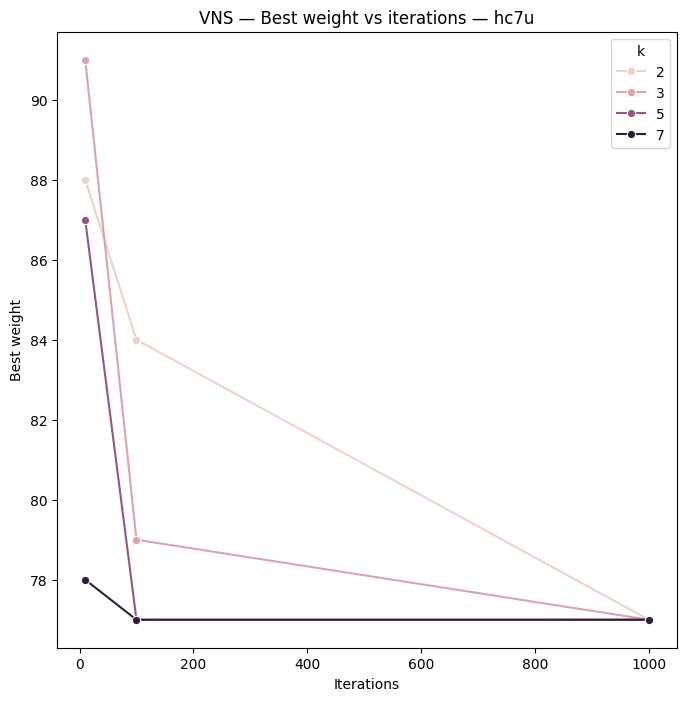

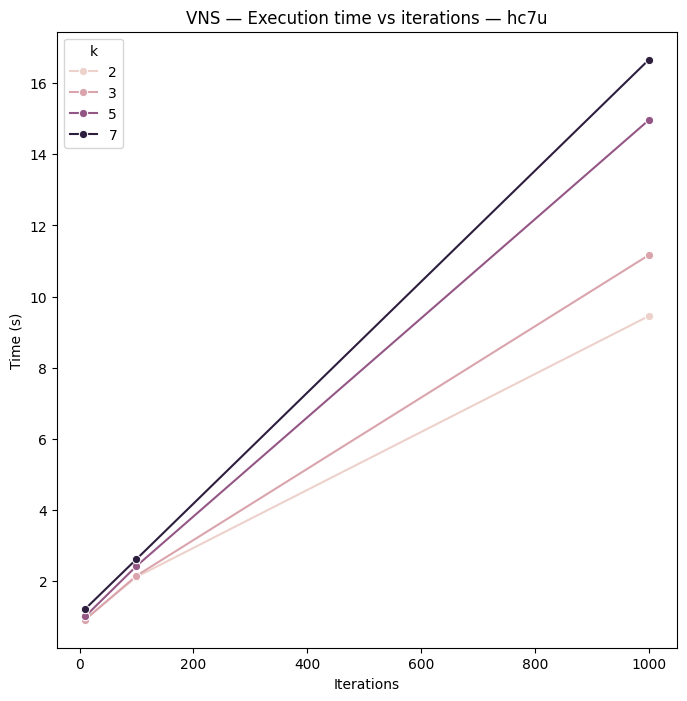

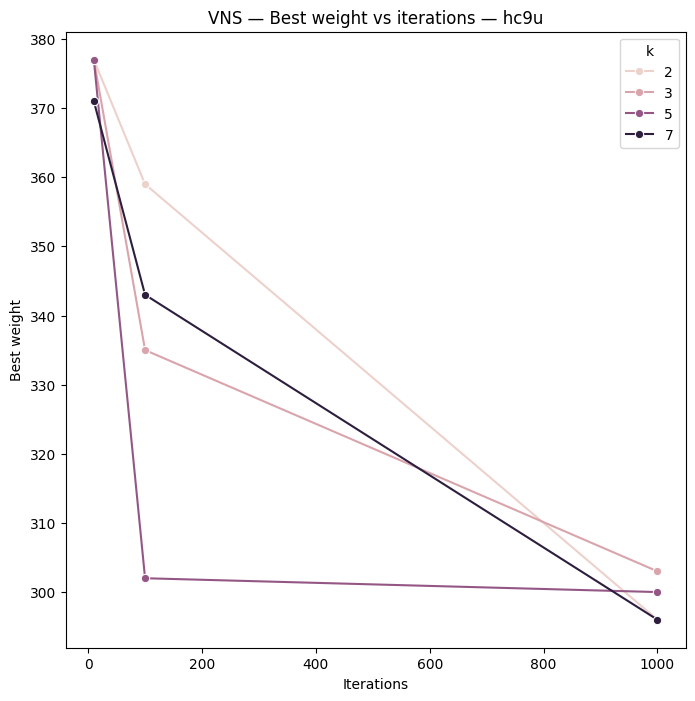

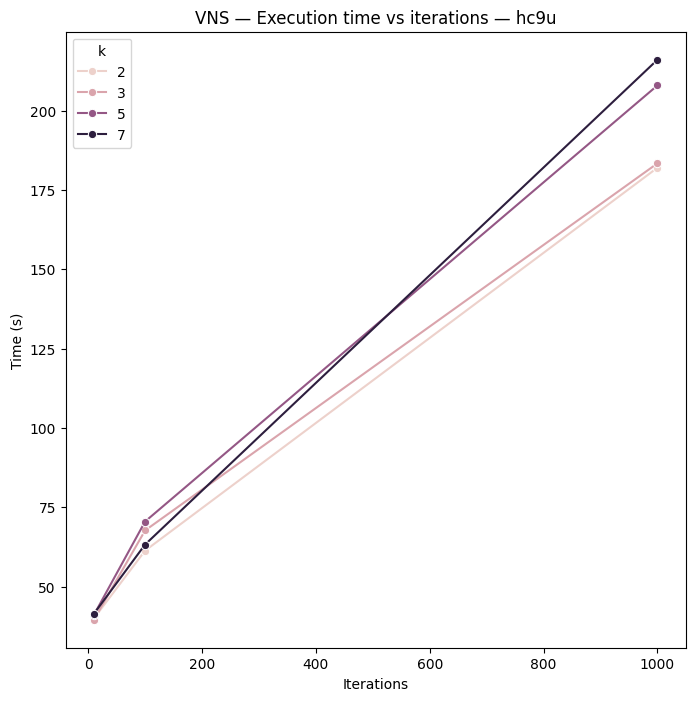

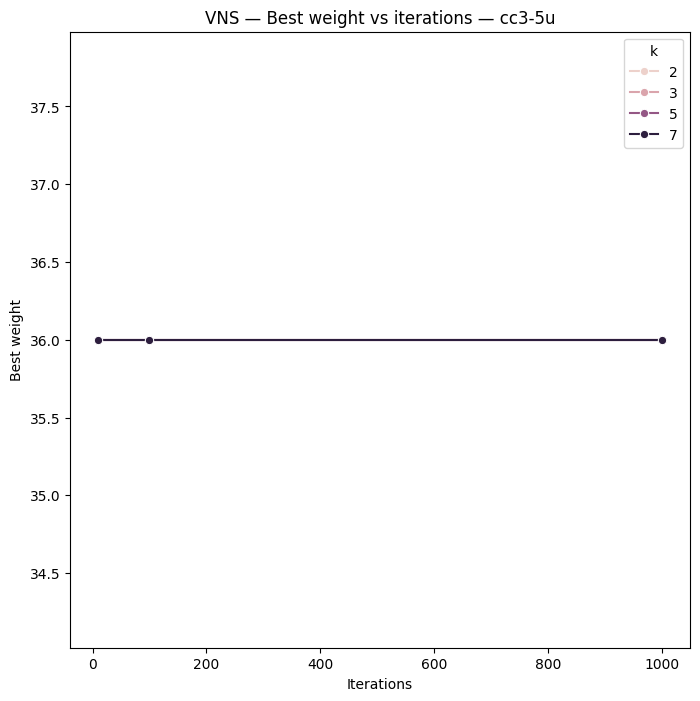

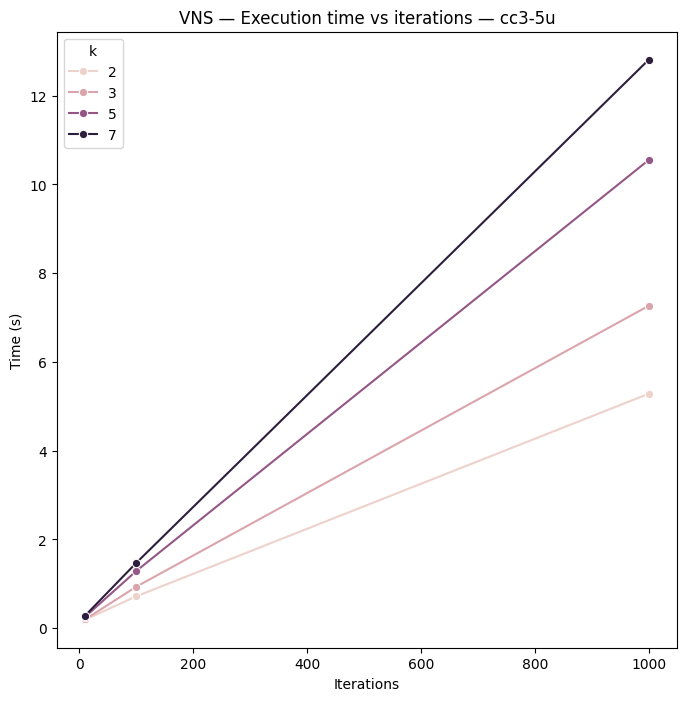

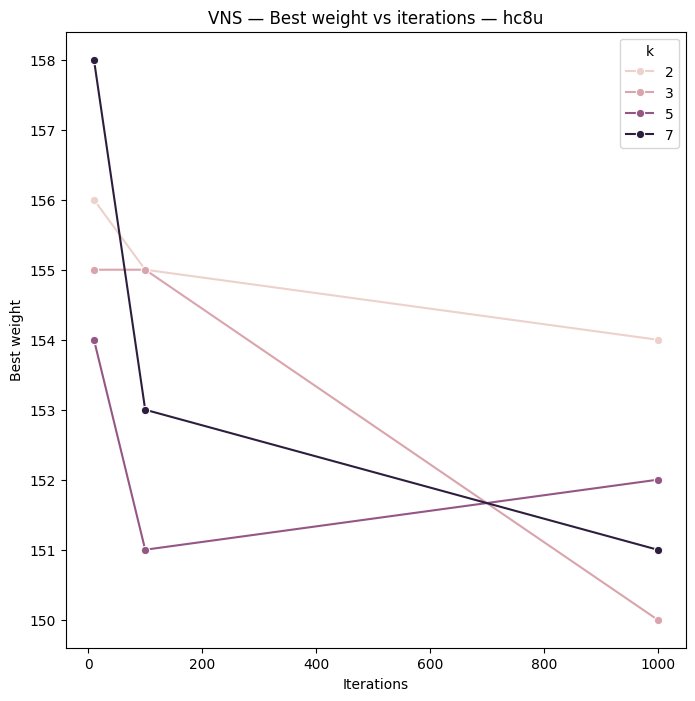

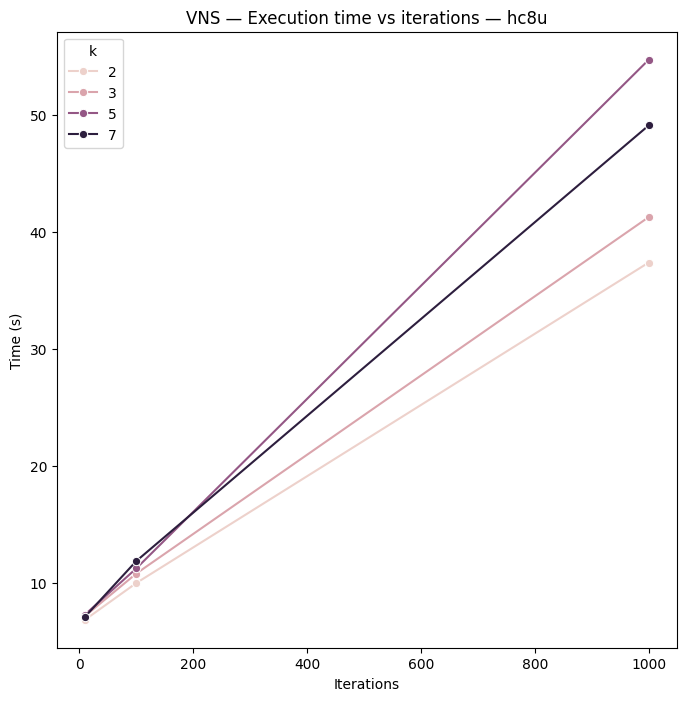

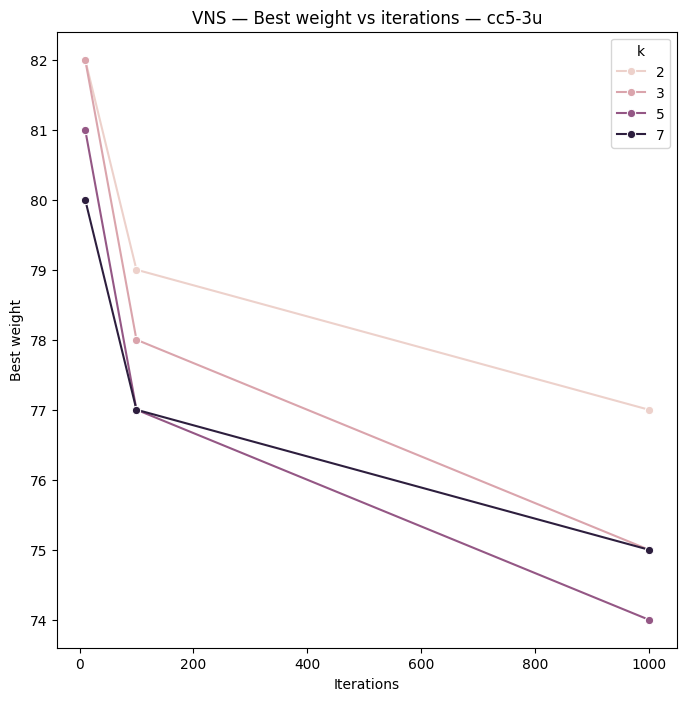

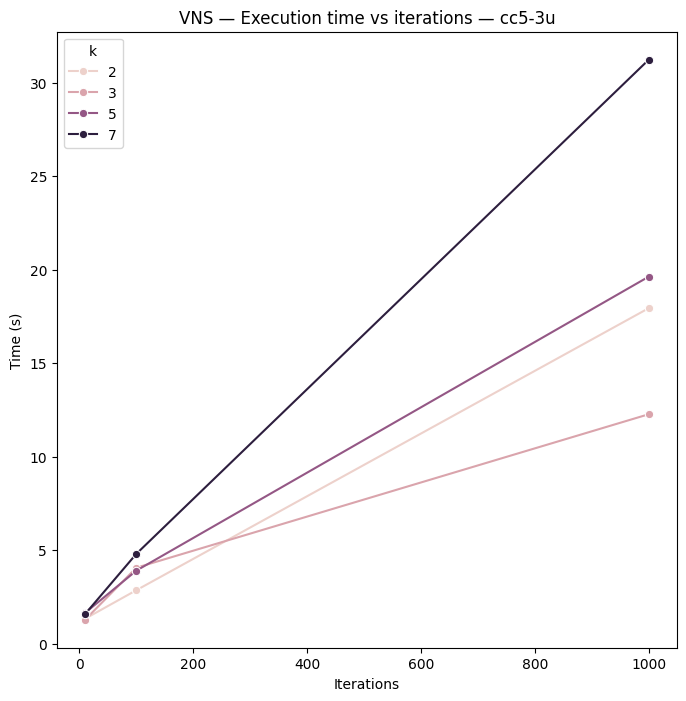

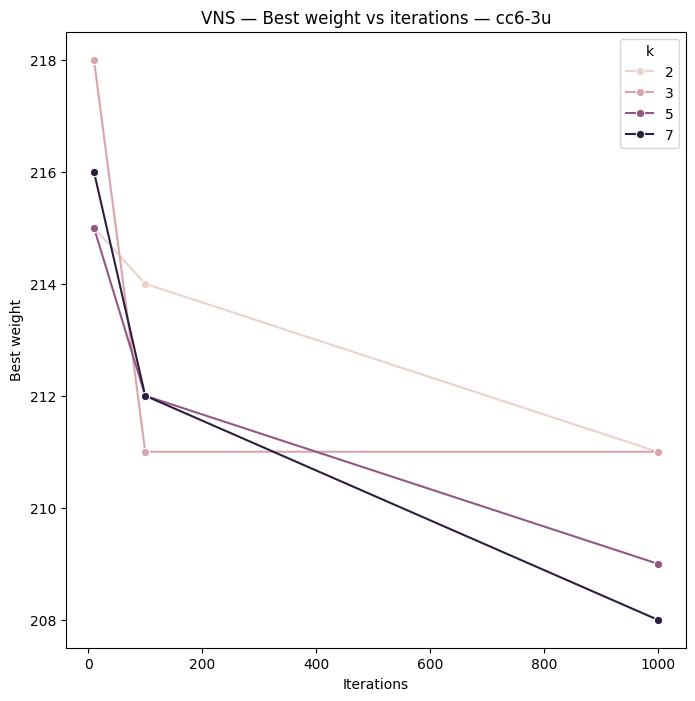

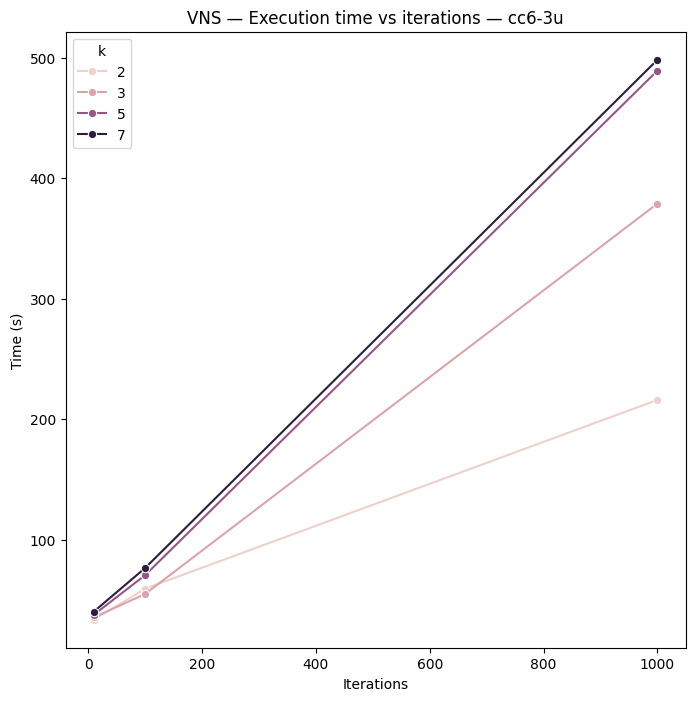

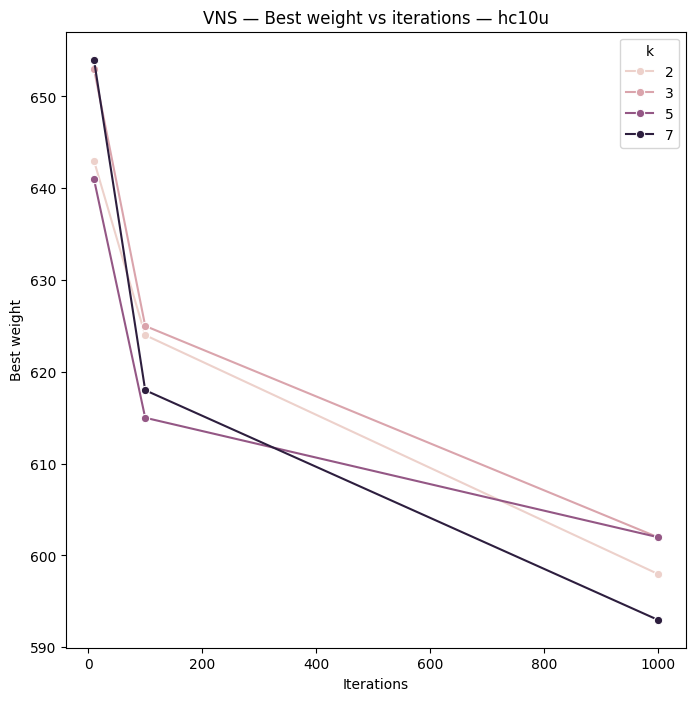

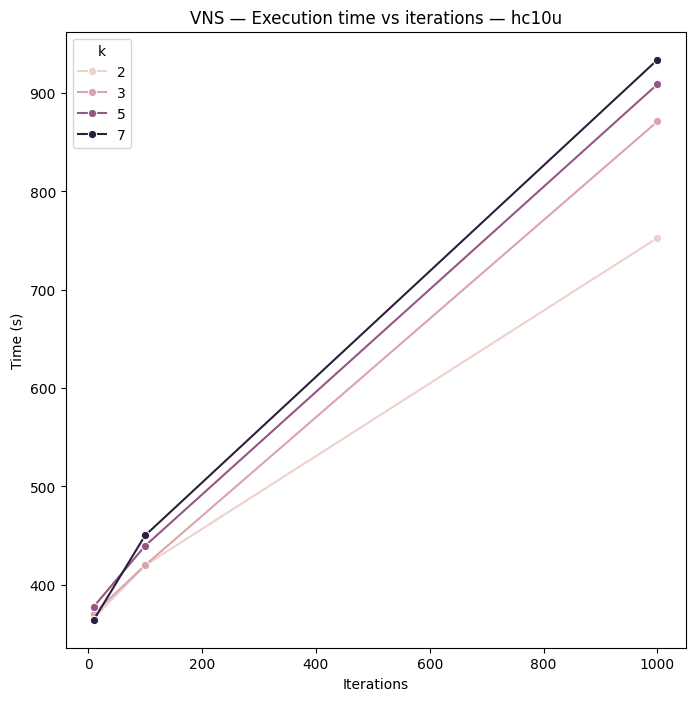

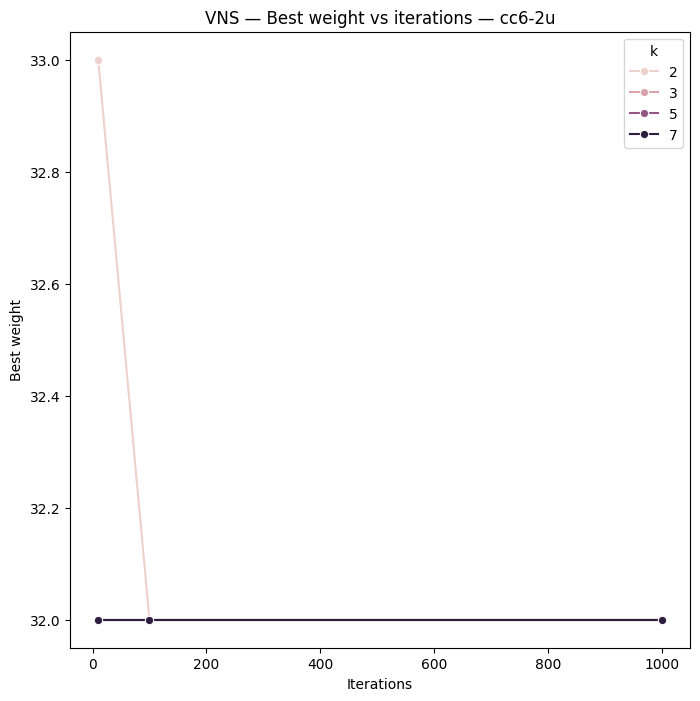

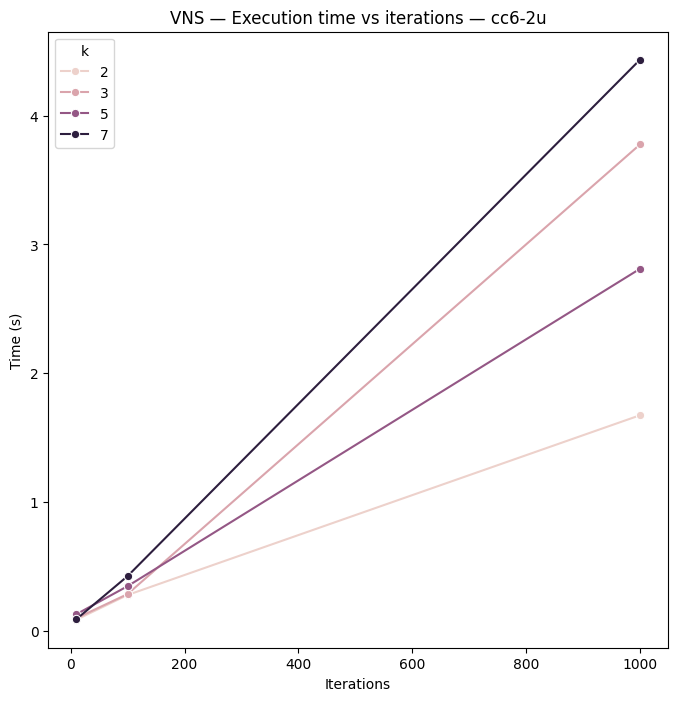

In [31]:
for g in df["graph_name"].unique():
    sub = df[df["graph_name"] == g]

    plt.figure(figsize = (8,8))
    sns.lineplot(data = sub, x = "iterations", y = "best_w", hue = "k", marker = "o")
    plt.title(f"VNS — Best weight vs iterations — {g}")
    plt.xlabel("Iterations")
    plt.ylabel("Best weight")
    plt.savefig(f"plots_vns/{g}_bestweight.png", dpi = 300, bbox_inches = "tight")
    plt.show()
    plt.close()
    
    plt.figure(figsize = (8,8))
    sns.lineplot(data = sub, x = "iterations", y = "time", hue = "k", marker = "o")
    plt.title(f"VNS — Execution time vs iterations — {g}")
    plt.xlabel("Iterations")
    plt.ylabel("Time (s)")
    plt.savefig(f"plots_vns/{g}_time.png", dpi = 300, bbox_inches = "tight")
    plt.show()
    plt.close()